In [1]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, Imputer, MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, ExtraTreesClassifier

In [2]:
RAND_SEED = 1
K_FOLD_NUM = 5

In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

# Clean Data

In [4]:
print train_df.info()
print test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

In [5]:
print train_df.describe()
print test_df.describe()

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
       PassengerId      Pclass         Age       SibSp       Parch        Fare
co

## Pclass

In [6]:
def joinFeatureDummies(in_data, feature_name):
    dummies = pd.get_dummies(in_data[feature_name], prefix=feature_name)
    return in_data.join(dummies)

In [7]:
train_df = joinFeatureDummies(train_df, 'Pclass')

## Sex

In [8]:
def get_sex_val(sex):
    return 0 if sex == 'male' else 1

In [9]:
train_df['SexVal'] = train_df['Sex'].apply(get_sex_val)

In [10]:
train_df['SexVal'].value_counts()

0    577
1    314
Name: SexVal, dtype: int64

In [11]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

## Age

In [12]:
train_df['AgeFill'] = train_df['Age']
train_df['AgeFill'] = train_df['AgeFill']\
    .groupby([train_df['SexVal'], train_df['Pclass']])\
    .apply(lambda x: x.fillna(x.median()))

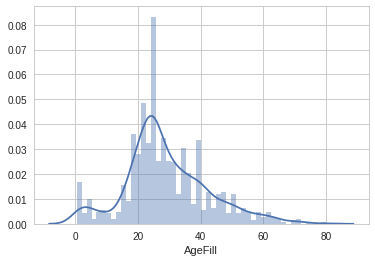

In [13]:
sns.distplot(train_df['AgeFill'], bins=50)

In [14]:
train_df['AgeFill'].describe()

count    891.000000
mean      29.112424
std       13.304424
min        0.420000
25%       21.500000
50%       26.000000
75%       36.000000
max       80.000000
Name: AgeFill, dtype: float64

## Family Size

In [15]:
train_df['Family'] = train_df['SibSp'] + train_df['Parch']

In [16]:
train_df['Family'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

## Fare

## Embarked

In [17]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
train_df['EmbarkedFill'] = train_df['Embarked'].fillna('S')

In [19]:
train_df = joinFeatureDummies(train_df, 'EmbarkedFill')

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
PassengerId       891 non-null int64
Survived          891 non-null int64
Pclass            891 non-null int64
Name              891 non-null object
Sex               891 non-null object
Age               714 non-null float64
SibSp             891 non-null int64
Parch             891 non-null int64
Ticket            891 non-null object
Fare              891 non-null float64
Cabin             204 non-null object
Embarked          889 non-null object
Pclass_1          891 non-null uint8
Pclass_2          891 non-null uint8
Pclass_3          891 non-null uint8
SexVal            891 non-null int64
AgeFill           891 non-null float64
Family            891 non-null int64
EmbarkedFill      891 non-null object
EmbarkedFill_C    891 non-null uint8
EmbarkedFill_Q    891 non-null uint8
EmbarkedFill_S    891 non-null uint8
dtypes: float64(3), int64(7), object(6), uint8(6)
memory usage: 116.7

In [21]:
feed_attr = ['Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'SexVal', 'AgeFill', 
    'Family', 'EmbarkedFill_C', 'EmbarkedFill_Q', 'EmbarkedFill_S']
X_train = train_df[feed_attr]
Y_train = train_df['Survived']

# Train Model

In [22]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=RAND_SEED)

In [23]:
rf.fit(X_train, Y_train)
rf.oob_score_

0.80695847362514028

In [24]:
d = {'Features': X_train.columns,  'Factor': rf.feature_importances_}
DataFrame(d).sort_values(by='Factor', ascending=False)

,Factor,Features
5,0.272476,AgeFill
0,0.266387,Fare
4,0.253859,SexVal
6,0.076408,Family
3,0.055242,Pclass_3
1,0.027633,Pclass_1
9,0.014805,EmbarkedFill_S
2,0.014753,Pclass_2
7,0.010438,EmbarkedFill_C
8,0.007998,EmbarkedFill_Q


In [25]:
def calcOOBScore(estimator_class, n_estimators, max_features, max_depth):
    print 'calcOOBScore parameter:', estimator_class.__name__, n_estimators, max_features, max_depth
    estimator = estimator_class(n_estimators=n_estimators, max_features=max_features, 
    max_depth=max_depth, oob_score=True, bootstrap=True, n_jobs=-1, random_state=RAND_SEED)
    estimator.fit(X_train, Y_train)
    print estimator.oob_score_
    return estimator

In [26]:
calcOOBScore(RandomForestClassifier, 100, 'auto', None)

calcOOBScore parameter: RandomForestClassifier 100 auto None
0.806958473625


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [27]:
n_estimators = np.arange(900, 4001, 1000)
max_features = [5, 6, 7]
for a in n_estimators:
    for b in max_features:
        calcOOBScore(ExtraTreesClassifier, a, b, 5)

calcOOBScore parameter: ExtraTreesClassifier 900 5 5
0.822671156004
calcOOBScore parameter: ExtraTreesClassifier 900 6 5
0.821548821549
calcOOBScore parameter: ExtraTreesClassifier 900 7 5
0.82379349046
calcOOBScore parameter: ExtraTreesClassifier 1900 5 5
0.821548821549
calcOOBScore parameter: ExtraTreesClassifier 1900 6 5
0.82379349046
calcOOBScore parameter: ExtraTreesClassifier 1900 7 5
0.822671156004
calcOOBScore parameter: ExtraTreesClassifier 2900 5 5
0.821548821549
calcOOBScore parameter: ExtraTreesClassifier 2900 6 5
0.82379349046
calcOOBScore parameter: ExtraTreesClassifier 2900 7 5
0.822671156004
calcOOBScore parameter: ExtraTreesClassifier 3900 5 5
0.821548821549
calcOOBScore parameter: ExtraTreesClassifier 3900 6 5
0.82379349046
calcOOBScore parameter: ExtraTreesClassifier 3900 7 5
0.821548821549


In [28]:
etc = calcOOBScore(ExtraTreesClassifier, 4000, 6, 5)

calcOOBScore parameter: ExtraTreesClassifier 4000 6 5
0.82379349046


In [29]:
print test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


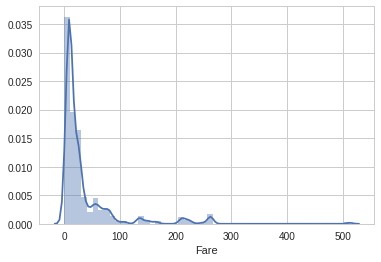

In [30]:
sns.distplot(test_df[test_df['Fare'].notnull()]['Fare'], bins=50)

In [31]:
def clean_data(df):
    df = joinFeatureDummies(df, 'Pclass')
    
    df['SexVal'] = df['Sex'].apply(get_sex_val)
    
    df['AgeFill'] = df['Age']
    df['AgeFill'] = df['AgeFill']\
        .groupby([df['SexVal'], df['Pclass']])\
        .apply(lambda x: x.fillna(x.median()))
    
    df['Family'] = df['SibSp'] + df['Parch']
    
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    df['EmbarkedFill'] = df['Embarked']
    df = joinFeatureDummies(df, 'EmbarkedFill')
    return df[feed_attr]

In [32]:
X_test = clean_data(test_df)

In [33]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Fare              418 non-null float64
Pclass_1          418 non-null uint8
Pclass_2          418 non-null uint8
Pclass_3          418 non-null uint8
SexVal            418 non-null int64
AgeFill           418 non-null float64
Family            418 non-null int64
EmbarkedFill_C    418 non-null uint8
EmbarkedFill_Q    418 non-null uint8
EmbarkedFill_S    418 non-null uint8
dtypes: float64(2), int64(2), uint8(6)
memory usage: 15.6 KB


In [34]:
from sklearn import metrics
from sklearn.cross_validation import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_train, 
                                                    Y_train, 
                                                    test_size=0.20, 
                                                    random_state=RAND_SEED)

/home/damonhao/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
etc = ExtraTreesClassifier(n_estimators=4000, max_features=6, 
    max_depth=5, oob_score=True, bootstrap=True, n_jobs=-1, random_state=RAND_SEED)

In [36]:
etc.fit(train_x, train_y)
predict_y = etc.predict(test_x)
from sklearn.metrics import accuracy_score
print ("Accuracy = %.6f" % (accuracy_score(test_y, predict_y)))

Accuracy = 0.776536


In [37]:
etc.oob_score_

0.8370786516853933

In [38]:
etc.score(test_x, test_y)

0.77653631284916202

In [39]:
Y_pred = etc.predict(X_test)
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"],"Survived": Y_pred})

In [40]:
submission.to_csv('titanic.csv', index=False)

In [41]:
etc

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=5, max_features=6, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=4000, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [42]:
Y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,